In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [3]:
import wandb
from wandb.keras import WandbCallback

In [4]:
wandb.init(project = "Stock Price Prediction",
    config={"hyper": "parameter"})

wandb: Currently logged in as: supe-one. Use `wandb login --relogin` to force relogin


#**Stock 1: IBM**

---

# **Importing the Data**

---



In [5]:
df = pd.read_csv("/content/drive/MyDrive/ME781/ibm.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,1.92,1.92,1.90,1.90,387200,0.0,0.0
1,1962-01-03,1.90,1.92,1.90,1.92,288000,0.0,0.0
2,1962-01-04,1.92,1.92,1.90,1.90,256000,0.0,0.0
3,1962-01-05,1.90,1.90,1.86,1.86,363200,0.0,0.0
4,1962-01-08,1.86,1.86,1.81,1.83,544000,0.0,0.0


In [6]:
# Dropping the rows with null values
df = df.dropna()

In [7]:
df.shape

(14708, 8)

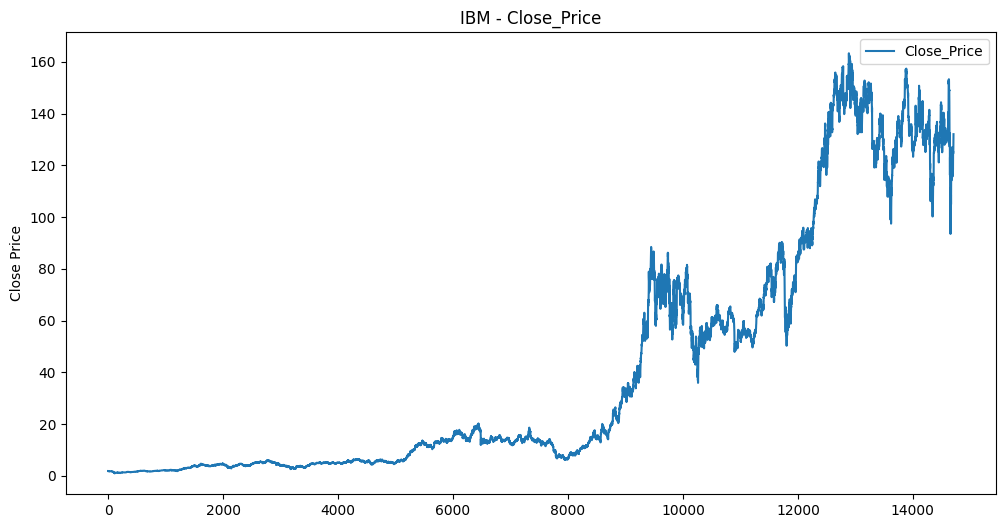

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close, label='Close_Price')
plt.title('IBM - Close_Price')
plt.ylabel('Close Price')
plt.legend()

In [9]:
# Creating an array of close values and normalising them
df_close = df.Close.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)

# **Creating the Dataset**

---



In [10]:
# Splitting the data into testing and training sets
train_size = 0.9
training_size=int(len(df_close)*train_size)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]
print("Train_data: ", train_data.shape)
print("Test_data: ", test_data.shape)

Train_data:  (13237, 1)
Test_data:  (1471, 1)


In [11]:
train_data

array([[0.00542206],
       [0.00554529],
       [0.00542206],
       ...,
       [0.92248922],
       [0.91133703],
       [0.89926063]])

In [12]:
# Creating batches of dataset of length = timestep
def create_dataset(df, timestep):
    df_X, df_y = [], []
    for i in range(len(df) - timestep):
        df_X.append(df[i:i + timestep, 0])
        df_y.append(df[i + timestep, 0])
    return np.array(df_X), np.array(df_y)

In [13]:
# Sliding window length= 60 days : Hyperparameter
timestep=60

X_train_lstm, y_train_lstm = create_dataset(train_data, timestep)
X_test_lstm, y_test_lstm = create_dataset(test_data, timestep)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1] , 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],X_test_lstm.shape[1] , 1)

print("X_train: ", X_train_lstm.shape)
print("y_train: ", y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("y_test", y_test_lstm.shape)

X_train:  (13177, 60, 1)
y_train:  (13177,)
X_test:  (1411, 60, 1)
y_test (1411,)


# **Model Definition: LSTM on Raw Data**

---



In [14]:
import tensorflow

In [15]:
from tensorflow.keras.models import Sequential

In [16]:
from tensorflow.keras.layers import LSTM

In [17]:
from tensorflow.keras.layers import Dropout

In [18]:
from tensorflow.keras.layers import Dense

In [19]:
from tensorflow.keras.layers import BatchNormalization

In [20]:
vanilla_lstm = Sequential([
    LSTM(units = 128, return_sequences = True, input_shape = (timestep, 1)),
    Dropout(rate = 0.15),

    LSTM(units = 128, return_sequences = True),
    LSTM(units = 128),
    Dense(units = 1)
])
vanilla_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

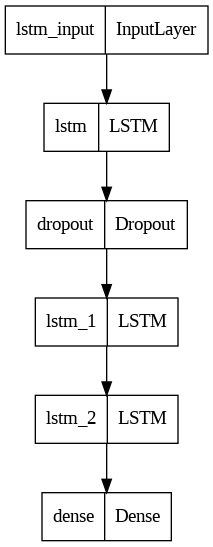

In [21]:
tensorflow.keras.utils.plot_model(vanilla_lstm)

In [22]:
vanilla_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 329857 (1.26 MB)
Trainable params: 329857 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Training: LSTM on Raw Data**

---



In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 1)
vanilla_lstm.fit(X_train_lstm, y_train_lstm, validation_data = (X_test_lstm, y_test_lstm), epochs = 50, batch_size = 64, callbacks = [early_stop])

Epoch 1/50
206/206 [==============================] - 25s 18ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2/50
206/206 [==============================] - 2s 12ms/step - loss: 2.3853e-04 - val_loss: 8.6730e-04
Epoch 3/50
206/206 [==============================] - 2s 12ms/step - loss: 1.7118e-04 - val_loss: 6.8809e-04
Epoch 4/50
206/206 [==============================] - 3s 14ms/step - loss: 1.5703e-04 - val_loss: 0.0014
Epoch 5/50
206/206 [==============================] - 4s 17ms/step - loss: 1.4806e-04 - val_loss: 0.0016
Epoch 6/50
206/206 [==============================] - 3s 16ms/step - loss: 1.5834e-04 - val_loss: 5.7990e-04


In [25]:
train_pred = scaler.inverse_transform(vanilla_lstm.predict(X_train_lstm))
y_train_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1,1))

412/412 [==============================] - 3s 5ms/step


In [26]:
test_pred = scaler.inverse_transform(vanilla_lstm.predict(X_test_lstm))
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

45/45 [==============================] - 0s 5ms/step


# **Model Performance**

---



In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mse_train = mean_squared_error(y_train_lstm, train_pred)
print(mse_train)

2.3226435918615707


In [29]:
mse_test = mean_squared_error(y_test_lstm, test_pred)
print(mse_test)

15.275306463706073


In [36]:
rmse_test = np.sqrt(mse_test)
print("Root Mean Squared Loss on IBM:", rmse_test)

Root Mean Squared Loss on IBM: 3.908363655509307


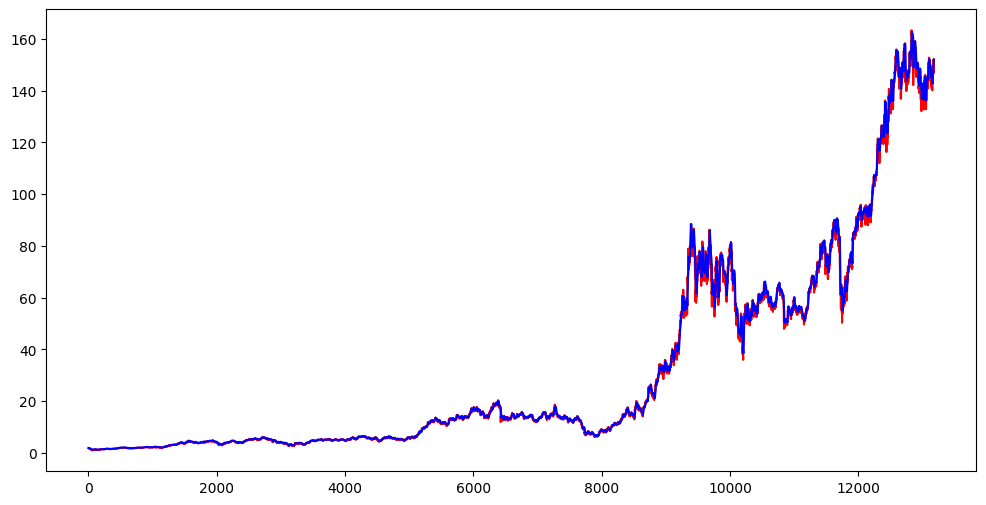

In [31]:
plt.figure(figsize = (12,6))
plt.plot(y_train_lstm, color = 'red')
plt.plot(train_pred, color = 'blue')

In [32]:
#Restrcuting the output to plot by date
dates = df['Date'][df.shape[0] - y_test_lstm.shape[0]:]
data = zip(dates.tolist(), np.reshape(y_test_lstm, y_test_lstm.shape[0]), np.reshape(test_pred, test_pred.shape[0]))
d = pd.DataFrame(data, columns = ['Dates', 'Actual', 'Predicted'] )
d.set_index('Dates', inplace = True)

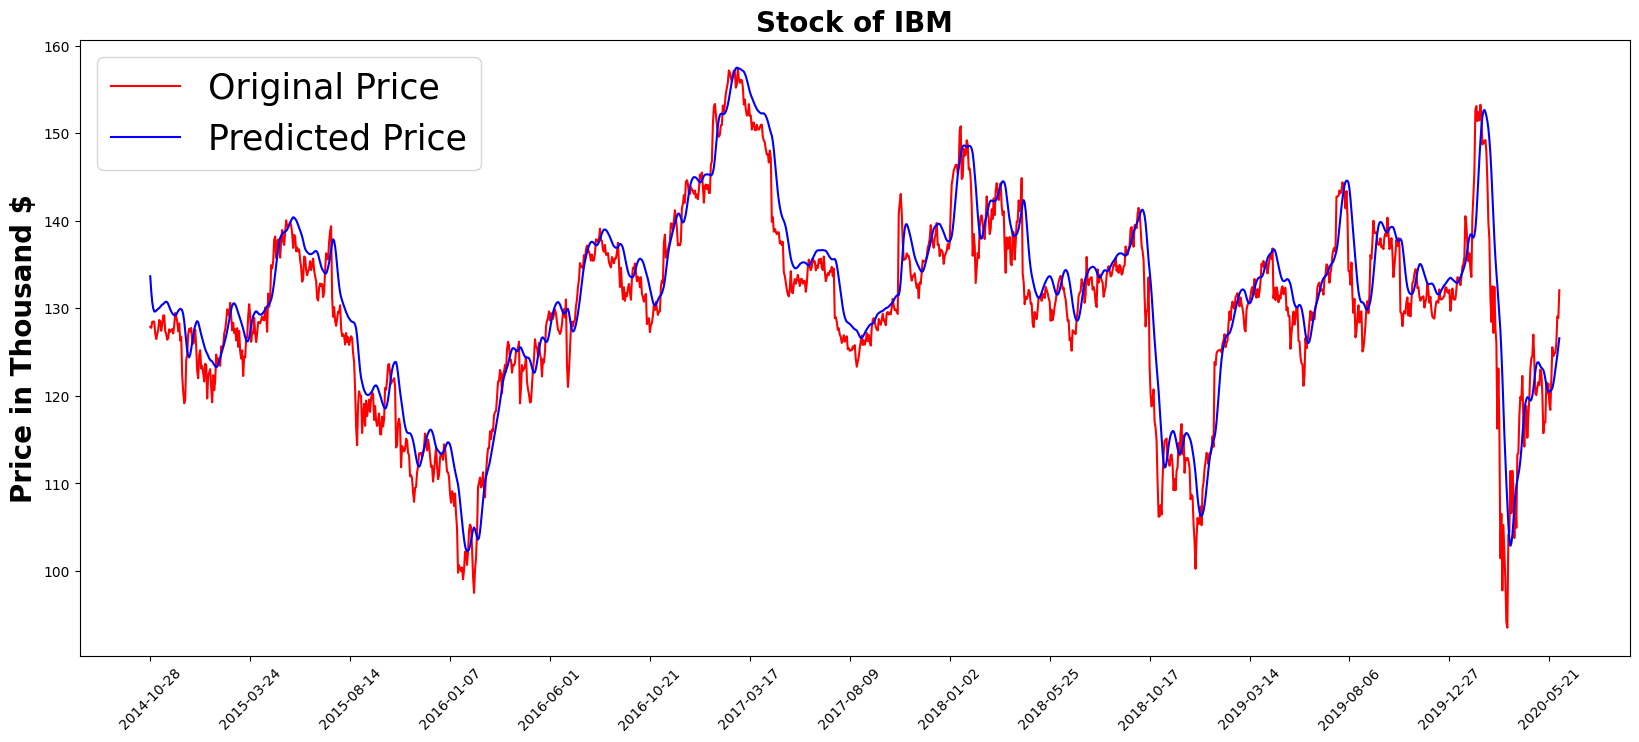

In [34]:
plt.figure(figsize = (20,8))
plt.plot(d.Actual, label='Original Price', color = 'red')
plt.plot(d.Predicted, label='Predicted Price', color = 'blue')
plt.title('Stock of IBM', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(np.arange(0, d.Predicted.shape[0], 100), rotation = 45)
plt.legend(prop={'size':25})
plt.show()

#**Stock 2: Apple**

---

# **Importing the Data**

---



In [65]:
df = pd.read_csv("/content/drive/MyDrive/ME781/aapl.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1,1980-12-15,0.39,0.39,0.38,0.38,43971200,0.0,0.0
2,1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
3,1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
4,1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0


In [66]:
# Dropping the rows with null values
df = df.dropna()

In [67]:
df.shape

(9954, 8)

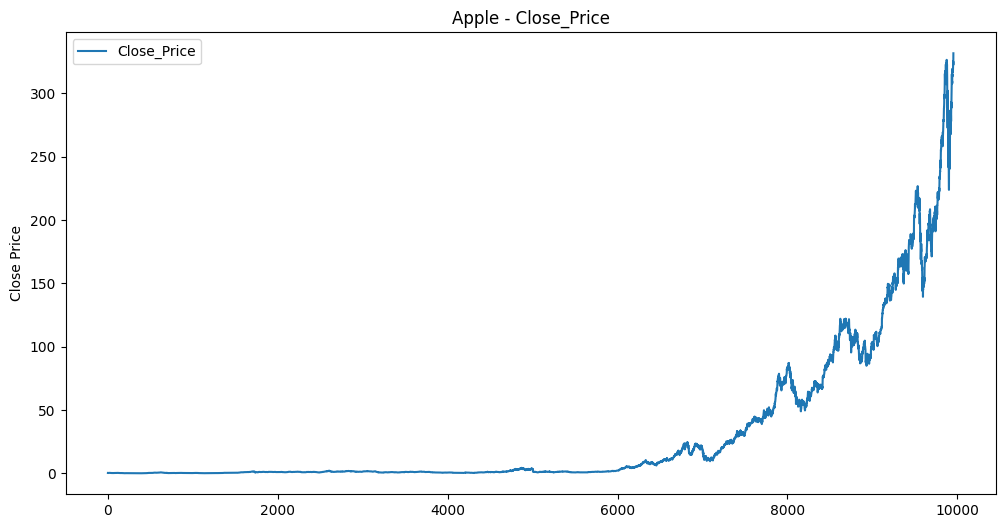

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close, label='Close_Price')
plt.title('Apple - Close_Price')
plt.ylabel('Close Price')
plt.legend()

In [69]:
# Creating an array of close values and normalising them
df_close = df.Close.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)

# **Creating the Dataset**

---



In [70]:
# Splitting the data into testing and training sets
train_size = 0.9
training_size=int(len(df_close)*train_size)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]
print("Train_data: ", train_data.shape)
print("Test_data: ", test_data.shape)

Train_data:  (8958, 1)
Test_data:  (996, 1)


In [71]:
train_data

array([[0.00075451],
       [0.00066397],
       [0.00060361],
       ...,
       [0.27011529],
       [0.26945132],
       [0.27174504]])

In [72]:
# Creating batches of dataset of length = timestep
def create_dataset(df, timestep):
    df_X, df_y = [], []
    for i in range(len(df) - timestep):
        df_X.append(df[i:i + timestep, 0])
        df_y.append(df[i + timestep, 0])
    return np.array(df_X), np.array(df_y)

In [73]:
# Sliding window length= 60 days : Hyperparameter
timestep=60

X_train_lstm, y_train_lstm = create_dataset(train_data, timestep)
X_test_lstm, y_test_lstm = create_dataset(test_data, timestep)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1] , 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],X_test_lstm.shape[1] , 1)

print("X_train: ", X_train_lstm.shape)
print("y_train: ", y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("y_test", y_test_lstm.shape)

X_train:  (8898, 60, 1)
y_train:  (8898,)
X_test:  (936, 60, 1)
y_test (936,)


# **Model Definition: LSTM on Raw Data**

---



In [74]:
import tensorflow

In [75]:
from tensorflow.keras.models import Sequential

In [76]:
from tensorflow.keras.layers import LSTM

In [77]:
from tensorflow.keras.layers import Dropout

In [78]:
from tensorflow.keras.layers import Dense

In [79]:
from tensorflow.keras.layers import BatchNormalization

In [80]:
vanilla_lstm = Sequential([
    LSTM(units = 128, return_sequences = True, input_shape = (timestep, 1)),
    Dropout(rate = 0.15),

    LSTM(units = 128, return_sequences = True),
    LSTM(units = 128),
    Dense(units = 1)
])
vanilla_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

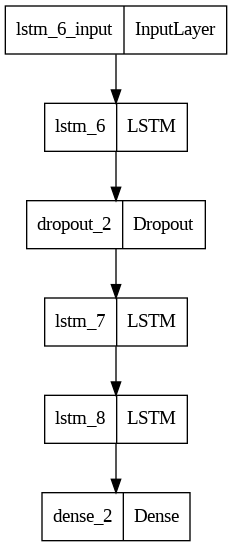

In [81]:
tensorflow.keras.utils.plot_model(vanilla_lstm)

In [82]:
vanilla_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 329857 (1.26 MB)
Trainable params: 329857 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Training: LSTM on Raw Data**

---



In [83]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 1)
vanilla_lstm.fit(X_train_lstm, y_train_lstm, validation_data = (X_test_lstm, y_test_lstm), epochs = 50, batch_size = 64, callbacks = [early_stop])

Epoch 1/50
140/140 [==============================] - 8s 20ms/step - loss: 1.9602e-04 - val_loss: 0.0011
Epoch 2/50
140/140 [==============================] - 2s 12ms/step - loss: 2.9049e-05 - val_loss: 0.0013
Epoch 3/50
140/140 [==============================] - 2s 14ms/step - loss: 4.4935e-05 - val_loss: 0.0029


In [84]:
train_pred = scaler.inverse_transform(vanilla_lstm.predict(X_train_lstm))
y_train_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1,1))

279/279 [==============================] - 3s 7ms/step


In [85]:
test_pred = scaler.inverse_transform(vanilla_lstm.predict(X_test_lstm))
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

30/30 [==============================] - 0s 7ms/step


# **Model Performance**

---



In [86]:
from sklearn.metrics import mean_squared_error

In [87]:
mse_train = mean_squared_error(y_train_lstm, train_pred)
print(mse_train)

5.142069182143114


In [88]:
mse_test = mean_squared_error(y_test_lstm, test_pred)
print(mse_test)

317.16286388104845


In [89]:
rmse_test = np.sqrt(mse_test)
print("Root Mean Squared Loss on Apple:", rmse_test)

Root Mean Squared Loss on Apple: 17.809066900908885


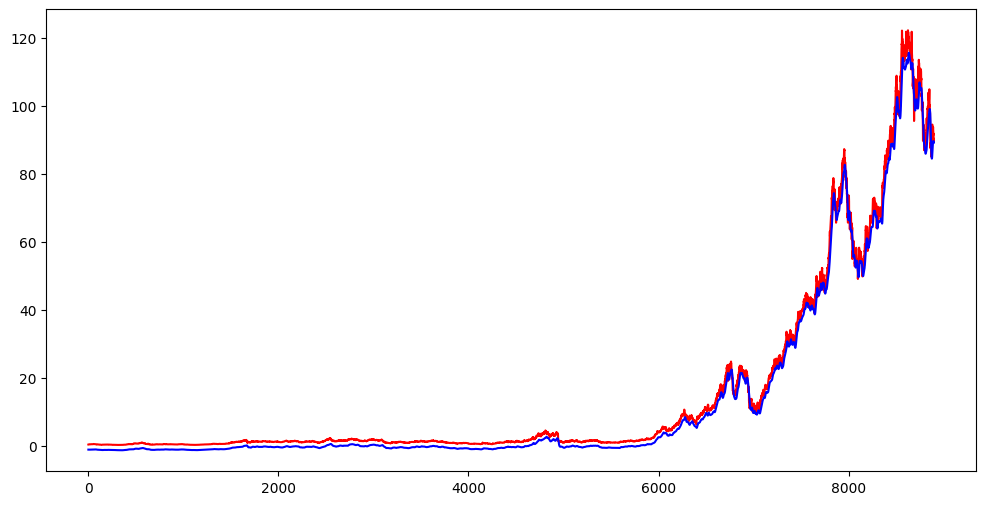

In [90]:
plt.figure(figsize = (12,6))
plt.plot(y_train_lstm, color = 'red')
plt.plot(train_pred, color = 'blue')

In [91]:
#Restrcuting the output to plot by date
dates = df['Date'][df.shape[0] - y_test_lstm.shape[0]:]
data = zip(dates.tolist(), np.reshape(y_test_lstm, y_test_lstm.shape[0]), np.reshape(test_pred, test_pred.shape[0]))
d = pd.DataFrame(data, columns = ['Dates', 'Actual', 'Predicted'] )
d.set_index('Dates', inplace = True)

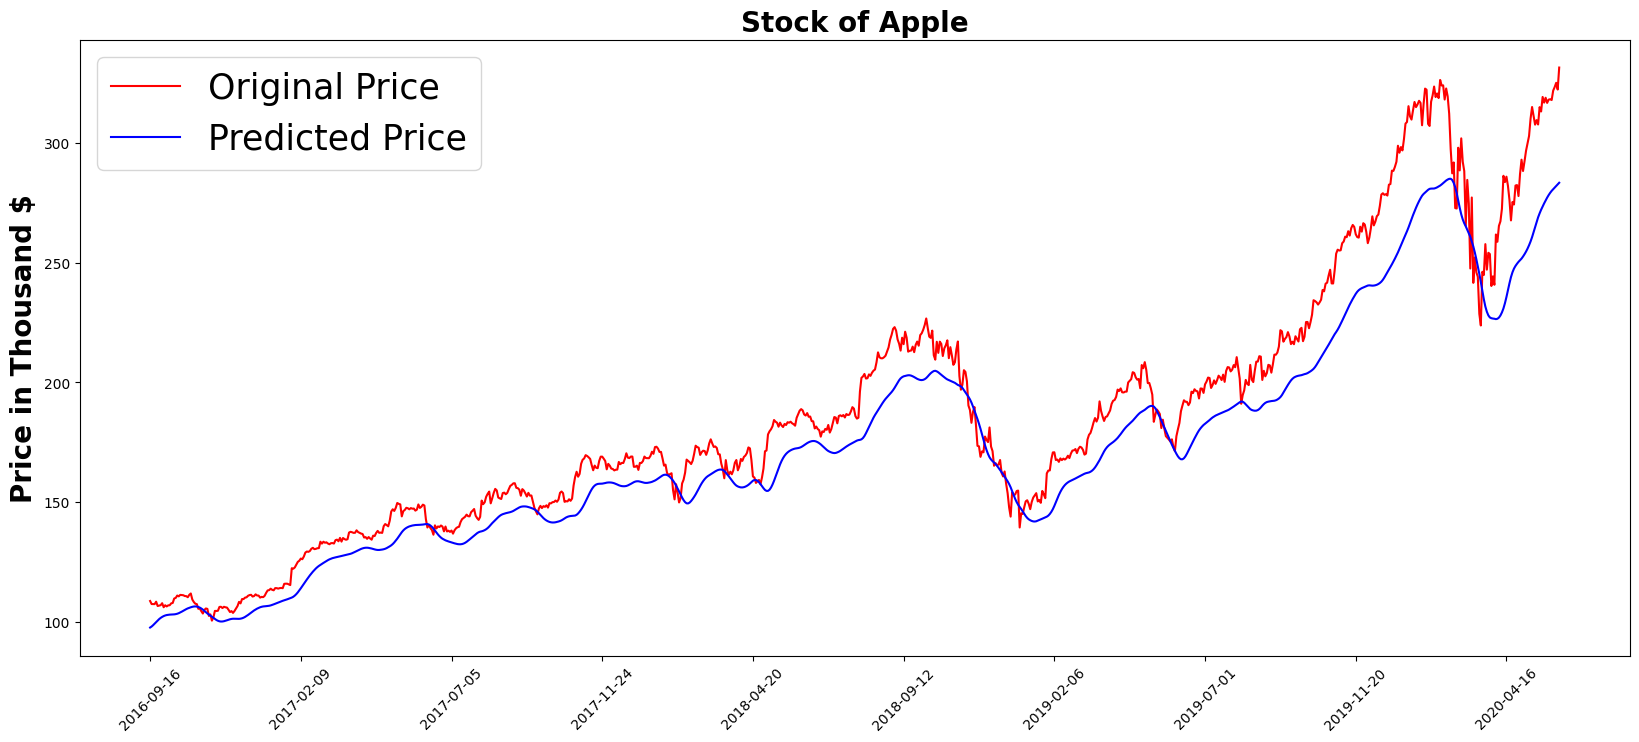

In [92]:
plt.figure(figsize = (20,8))
plt.plot(d.Actual, label='Original Price', color = 'red')
plt.plot(d.Predicted, label='Predicted Price', color = 'blue')
plt.title('Stock of Apple', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(np.arange(0, d.Predicted.shape[0], 100), rotation = 45)
plt.legend(prop={'size':25})
plt.show()

#**Stock 3: Facebook**

---

# **Importing the Data**

---



In [93]:
df = pd.read_csv("/content/drive/MyDrive/ME781/ibm.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,1.92,1.92,1.90,1.90,387200,0.0,0.0
1,1962-01-03,1.90,1.92,1.90,1.92,288000,0.0,0.0
2,1962-01-04,1.92,1.92,1.90,1.90,256000,0.0,0.0
3,1962-01-05,1.90,1.90,1.86,1.86,363200,0.0,0.0
4,1962-01-08,1.86,1.86,1.81,1.83,544000,0.0,0.0


In [94]:
# Dropping the rows with null values
df = df.dropna()

In [95]:
df.shape

(14708, 8)

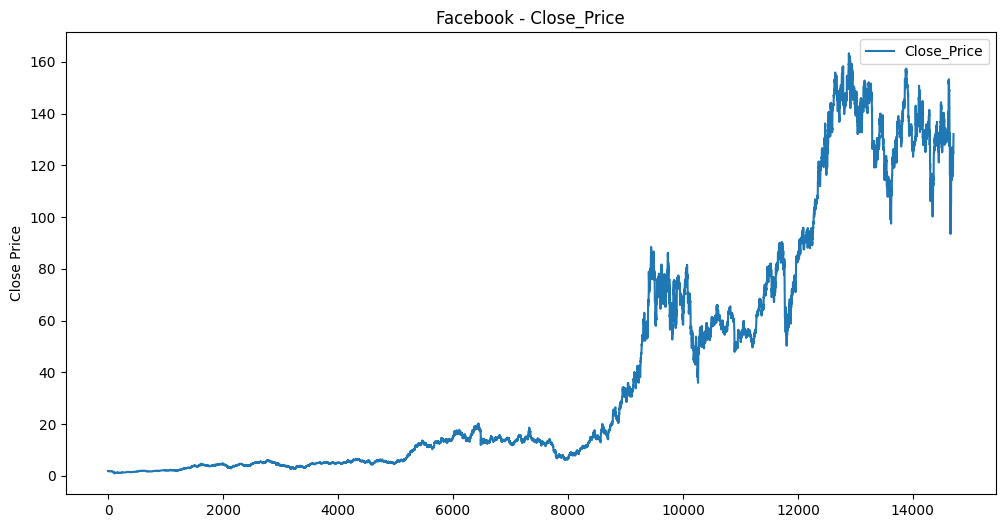

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close, label='Close_Price')
plt.title('Facebook - Close_Price')
plt.ylabel('Close Price')
plt.legend()

In [97]:
# Creating an array of close values and normalising them
df_close = df.Close.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)

# **Creating the Dataset**

---



In [98]:
# Splitting the data into testing and training sets
train_size = 0.9
training_size=int(len(df_close)*train_size)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]
print("Train_data: ", train_data.shape)
print("Test_data: ", test_data.shape)

Train_data:  (13237, 1)
Test_data:  (1471, 1)


In [99]:
train_data

array([[0.00542206],
       [0.00554529],
       [0.00542206],
       ...,
       [0.92248922],
       [0.91133703],
       [0.89926063]])

In [100]:
# Creating batches of dataset of length = timestep
def create_dataset(df, timestep):
    df_X, df_y = [], []
    for i in range(len(df) - timestep):
        df_X.append(df[i:i + timestep, 0])
        df_y.append(df[i + timestep, 0])
    return np.array(df_X), np.array(df_y)

In [101]:
# Sliding window length= 60 days : Hyperparameter
timestep=60

X_train_lstm, y_train_lstm = create_dataset(train_data, timestep)
X_test_lstm, y_test_lstm = create_dataset(test_data, timestep)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1] , 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],X_test_lstm.shape[1] , 1)

print("X_train: ", X_train_lstm.shape)
print("y_train: ", y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("y_test", y_test_lstm.shape)

X_train:  (13177, 60, 1)
y_train:  (13177,)
X_test:  (1411, 60, 1)
y_test (1411,)


# **Model Definition: LSTM on Raw Data**

---



In [102]:
import tensorflow

In [103]:
from tensorflow.keras.models import Sequential

In [104]:
from tensorflow.keras.layers import LSTM

In [105]:
from tensorflow.keras.layers import Dropout

In [106]:
from tensorflow.keras.layers import Dense

In [107]:
from tensorflow.keras.layers import BatchNormalization

In [108]:
vanilla_lstm = Sequential([
    LSTM(units = 128, return_sequences = True, input_shape = (timestep, 1)),
    Dropout(rate = 0.15),

    LSTM(units = 128, return_sequences = True),
    LSTM(units = 128),
    Dense(units = 1)
])
vanilla_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

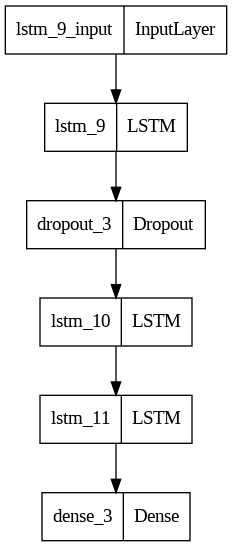

In [109]:
tensorflow.keras.utils.plot_model(vanilla_lstm)

In [110]:
vanilla_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 329857 (1.26 MB)
Trainable params: 329857 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Training: LSTM on Raw Data**

---



In [111]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 1)
vanilla_lstm.fit(X_train_lstm, y_train_lstm, validation_data = (X_test_lstm, y_test_lstm), epochs = 50, batch_size = 64, callbacks = [early_stop])

Epoch 1/50
206/206 [==============================] - 10s 18ms/step - loss: 0.0017 - val_loss: 9.8433e-04
Epoch 2/50
206/206 [==============================] - 3s 12ms/step - loss: 1.7100e-04 - val_loss: 8.7707e-04
Epoch 3/50
206/206 [==============================] - 3s 13ms/step - loss: 1.8029e-04 - val_loss: 0.0014


In [112]:
train_pred = scaler.inverse_transform(vanilla_lstm.predict(X_train_lstm))
y_train_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1,1))

412/412 [==============================] - 4s 7ms/step


In [113]:
test_pred = scaler.inverse_transform(vanilla_lstm.predict(X_test_lstm))
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

45/45 [==============================] - 0s 7ms/step


# **Model Performance**

---



In [114]:
from sklearn.metrics import mean_squared_error

In [115]:
mse_train = mean_squared_error(y_train_lstm, train_pred)
print(mse_train)

5.385019066850634


In [116]:
mse_test = mean_squared_error(y_test_lstm, test_pred)
print(mse_test)

36.098282002725355


In [117]:
rmse_test = np.sqrt(mse_test)
print("Root Mean Squared Loss on Facebook:", rmse_test)

Root Mean Squared Loss on Facebook: 6.008184584608346


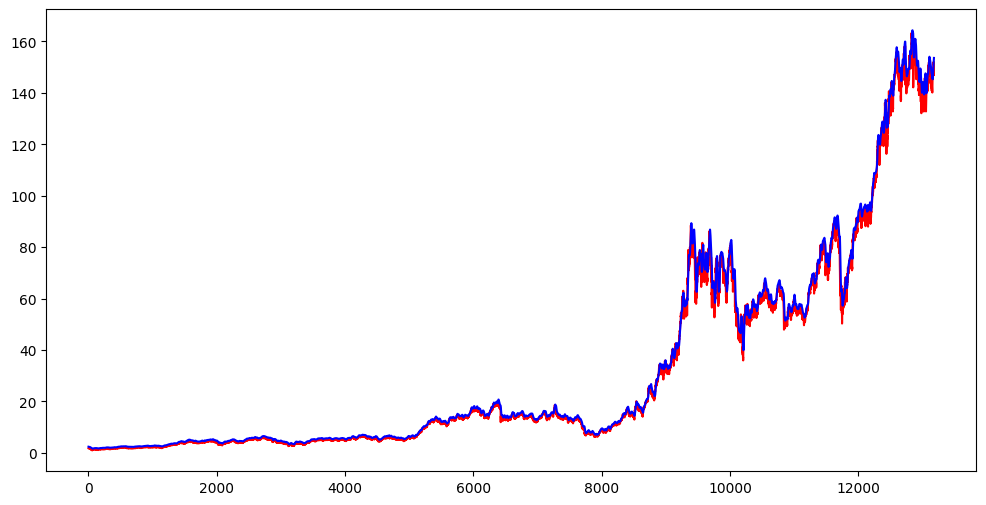

In [118]:
plt.figure(figsize = (12,6))
plt.plot(y_train_lstm, color = 'red')
plt.plot(train_pred, color = 'blue')

In [119]:
#Restrcuting the output to plot by date
dates = df['Date'][df.shape[0] - y_test_lstm.shape[0]:]
data = zip(dates.tolist(), np.reshape(y_test_lstm, y_test_lstm.shape[0]), np.reshape(test_pred, test_pred.shape[0]))
d = pd.DataFrame(data, columns = ['Dates', 'Actual', 'Predicted'] )
d.set_index('Dates', inplace = True)

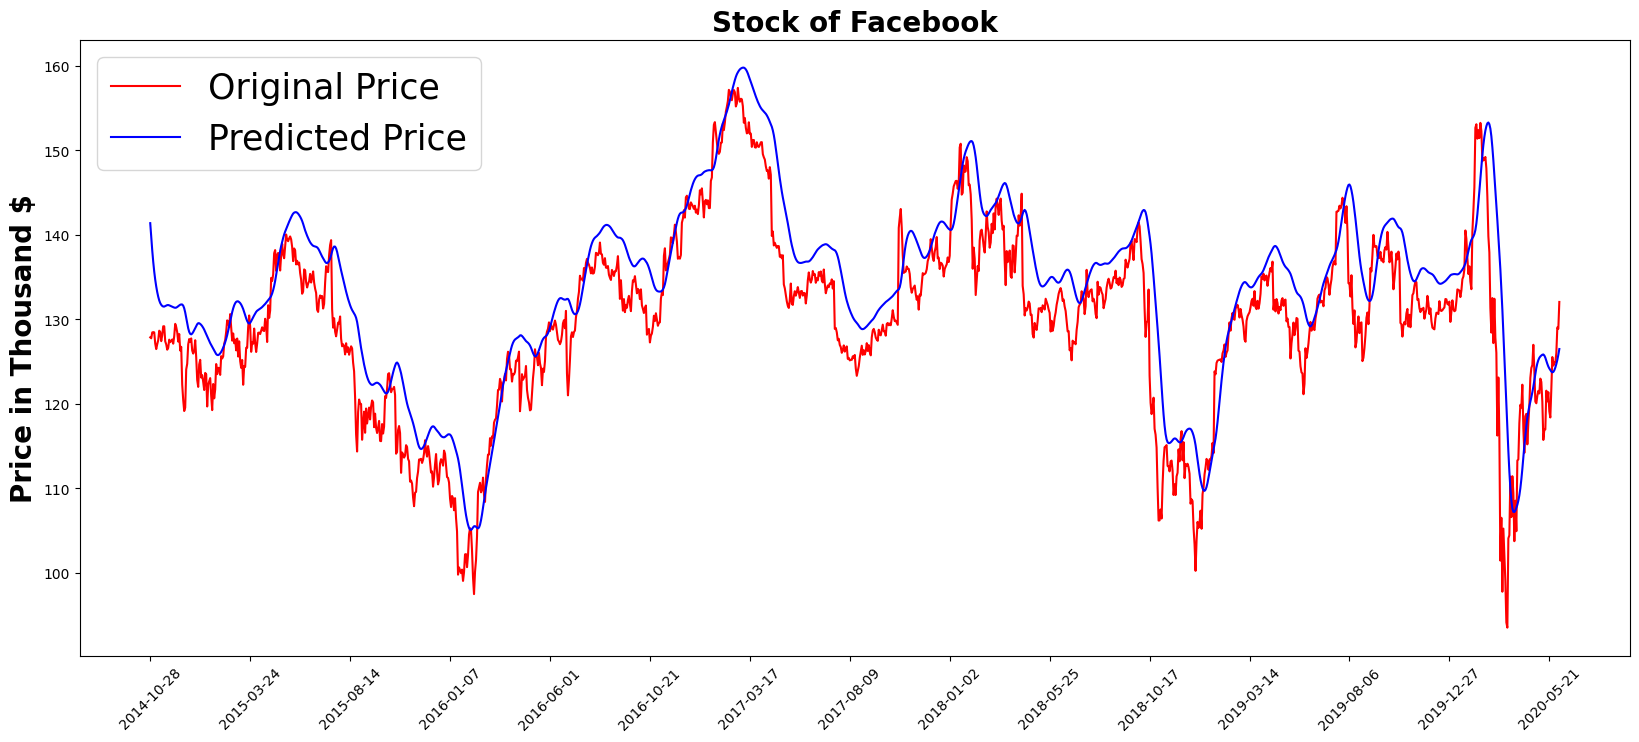

In [120]:
plt.figure(figsize = (20,8))
plt.plot(d.Actual, label='Original Price', color = 'red')
plt.plot(d.Predicted, label='Predicted Price', color = 'blue')
plt.title('Stock of Facebook', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(np.arange(0, d.Predicted.shape[0], 100), rotation = 45)
plt.legend(prop={'size':25})
plt.show()